In [1]:
%matplotlib inline

# 基础理论

逻辑回归分类器不仅是可以通过梯度下降进行优化的一种有用的在线学习方法，而且可以给出待预测问题可能发生的概率。

对于许多应用实践来说，我们不但对类标预测感兴趣，而且对事件属于某一类别的概率进行预测也非常有用，如天气预报、患病概率等。逻辑回归分类器就是利用概率来实现分类的算法。

逻辑回归分类器是针对**线性可分**问题的一种易于实现且性能优异的分类模型。它是业界应用最为广泛的分类模型之一。与感知器及Adaline类似，逻辑回归分类器也是适用于二分类问题的线性模型，并可以通过一对多（OvR）技术可以扩展到多类别分类。

逻辑回归分类器的计算流程与Adline相同，不同之处在于逻辑回归分类器的**激励函数**为sigmoid函数$\phi(z)$，它以实数值作为输入并将其映射到[0, 1]区间，其拐点位于$\phi(z)=0.5$处。sigmoid函数的形式如下：

$$\phi(z)=\frac{1}{1+e^{-z}}, \qquad z = \mathbf{w}^T \mathbf{x} = \sum_{i=0}^{m}{w_m x_m} = {w_0 x_0} + {w_1 x_1} + ... + {w_m x_m}$$

In [2]:
%%html
<img src="img/Sigmoid function.png">

sigmoid函数的输出结果为预测事件的发生**概率P**，如$\phi(z)=P(y=1|\mathbf{x};\mathbf{w})$。以Iris数据集为例，假设我们只对变色鸢尾和山鸢尾进行分类，且令y=1对应为变色鸢尾。如果针对某一样本，我们求得$\phi(z)=P(y=1|\mathbf{x};\mathbf{w})=0.8$，这意味着该样本为变色鸢尾的概率为80%，而该样本为山鸢尾的概率为20%。

可以通过一个量化器（单位阶跃函数）将sigmoid函数得到的概率转换为二元输出形式：

$$\hat{y}=
\begin{cases}
0,& if \ \phi(z) \ge 0.5\\
1,& otherwise
\end{cases}$$

对于sigmoid函数的图像（考虑拐点位置），该量化器等同于：

$$\hat{y}=
\begin{cases}
0,& if \ z \ge 0.0\\
1,& otherwise
\end{cases}$$

由于逻辑回归分类器涉及到事件的发生概率，因此需要借助最大似然函数$L(\mathbf{w})$推导出逻辑回归模型的**代价函数**$J(w)$。

假设数据集中的每个样本都是相互独立的，则最大似然函数$L(\mathbf{w})$的计算公式如下：

$$L(\mathbf{w}) = P(y|\mathbf{x}; \mathbf{w}) = \prod_{i=1}^{n}{P(y^{(i)}|x^{(i)}; \mathbf{w})} = (\phi(z^{(i)}))^{y^{(i)}} (1 - \phi(z^{(i)}))^{1-y^{(i)}}$$

其中：

$$z^{(i)} = \mathbf{w}^T x^{(i)} = \sum_{i=0}^{m}{w_m x_m^{(i)}} = {w_0 x_0^{(i)}} + {w_1 x_1^{(i)}} + ... + {w_m x_m^{(i)}}$$

逻辑回归模型的代价函数可定义为$J(\mathbf{w})=-log(L(\mathbf{w}))$，即：

$$J(\mathbf{w})=-log(L(\mathbf{w})) = -\sum_{i=1}^{n}{[y^{(i)} log(\phi(z^{(i)})) + (1-y^{(i)}) log(1-\phi(z^{(i)}))]}$$

对于单个样本，其误差函数可以表示为以下形式：

$$J(\phi(z), y; \mathbf{w})=
\begin{cases}
-log(\phi(z)),& if \ y=1\\
-log(1 - \phi(z)),& if \ y=0
\end{cases}$$

In [3]:
%%html
<img src="img/Logistic regression_cost function.png">

可见，如果将样本正确划分到类别1中，代价将趋近于0（实线）。类似地，如果正确将样本划分到类别0中，代价也将趋近于0（虚线）。但是，如果分类错误，代价将趋近于无穷。这也就意味着错误预测带来的代价将越来越大。

同样可以利用梯度下降算法对代价函数$J(w)$进行最小化处理，从而获得逻辑回归模型的参数（权重$\mathbf{w}$）。可以证明，逻辑回归模型中的回归系数更新用到的梯度下降算法本质上与Adaline所使用的梯度下降公式是相同的，即：

$$w_j := w_j + \Delta w_j$$

$$\Delta w_j = \eta \frac{\partial J}{\partial w_j} = \eta \sum_{i=1}^{n}{[y^{(i)} - \phi(z^{(i)})]x^{(i)}}$$

需要说明的是， 为避免**过拟合**现象，往往会在逻辑回归模型的代价函数中引入**正则化项**，以降低回归系数带来的副作用：

$$J(\mathbf{w}) = -\sum_{i=1}^{n}{[y^{(i)} log(\phi(z^{(i)})) + (1-y^{(i)}) log(1-\phi(z^{(i)}))] + \frac{\lambda}{2}||w||^2}$$

其中$\lambda$为正则化系数，在`scikit-learn`库的`LogisticRegression`类中通过参数C（$\lambda$的倒数）定义。

# Coding

使用`scikit-learn`训练一个逻辑回归分类器, 并将其运用于Iris数据集中。

In [1]:
# 导入需要的库

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 辅助函数

借助以下`plot_decision_region()`函数，可以绘制模型的决策区域，并观察不同样本的分类效果；其中，使用灰色小圆圈显示来自测试数据集的样本。

In [9]:
# %load scripts/plot_decision_region.py
# @Time    : 2018/5/10 22:45
# @Author  : SHeynckes
# @Email   : sheynckes@outlook.com
# @File    : plot_decision_region.py
# @Software: PyCharm


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min = X[:, 0].min() - 1
    x1_max = X[:, 0].max() + 1
    x2_min = X[:, 1].min() - 1
    x2_max = X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
                    c=cmap(idx), marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        X_test = X[test_idx, :]
        y_test = y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c="grey", alpha=1.0,
                    linewidth=1, marker="o", s=55, label="Test Set")

## 数据准备

首先，通过`scikit-learn`中的`datasets`直接导入Iris数据集。提取150个花朵样本中的花瓣长度（petal length）和花瓣宽度（petal width）两个特征的值，并由此构建特征矩阵X，同时将对应花朵所属类型的类标赋值给向量y。

同时，为了评估训练得到的模型在未知数据上的表现，需要将数据集划分为训练数据集(含有105个数据）和测试数据集（含有45个数据）。

In [2]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

使用`scikit-learn`的`preprocessing`模块中的`StandardScaler`类对特征进行标准化处理。使用`StandardScaler`中的`fit()`方法，可以计算训练数据中每个特征的$\mu$（样本均值）和$\sigma$（标准差）。通过调用`transform()`方法，可以使用前面计算得到的$\mu$和$\sigma$来对训练数据做标准化处理。需注意的是，我们要使用相同的缩放参数分别处理训练和测试数据集，以保证它们的值是彼此相当的。

In [3]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## 构建逻辑回归分类模型

接下来，就可以对逻辑回归分类模型进行训练了。该模型中的参数C是正则化系数的倒数。在逻辑回归模型的代价函数中引入正则化项，可以有效的避免过拟合。

完成模型的训练后，就可以在测试数据集上使用`predict()`方法进行预测了。可以看到，在逻辑回归模型对45朵花的分类结果中，有1个是错误的。

In [5]:
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
print("Misclassified samples: %d" % (y_test != y_pred).sum())

Misclassified samples: 1


在`scikit-learn`的`metrics`模块中，还实现了许多不同的性能矩阵。例如，可以通过下列代码计算逻辑回归模型在测试数据集上的分类准确率。

In [6]:
print("Accuracy: %.2f" % accuracy_score(y_test, y_pred))

Accuracy: 0.98


利用`plot_decision_regions()`函数绘制模型的决策区域，并观察不同样本的分类效果。

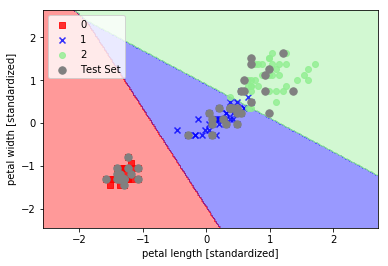

In [10]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=lr, test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc="upper left")
plt.show()

## 参数C的调试

以下代码比较了不同参数C对逻辑回归模型中权重参数拟合结果的影响规律。使用10个不同的参数C对逻辑回归模型进行拟合，并绘制其权重参数随C的变化情况。可以看到，如果减小参数C的值，也就是增加正则化项的强度，可以导致权重系数逐渐收缩。

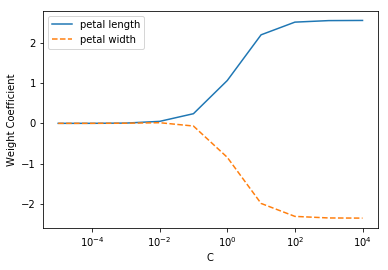

In [11]:
weights = []
params = []

for c in np.arange(-5.0, 5.0):
    lr_c = LogisticRegression(C=10**c, random_state=0)
    lr_c.fit(X_train_std, y_train)
    weights.append(lr_c.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label="petal length")
plt.plot(params, weights[:, 1], linestyle="--", label="petal width")
plt.xlabel("C")
plt.ylabel("Weight Coefficient")
plt.xscale("log")
plt.legend(loc="upper left")
plt.show()